# Strong Selection Regime

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [10]:
using Revise, Plots, Polynomials, LinearAlgebra, CSV, DataFrames, LaTeXStrings, Statistics, Measures

using Jedi, Jevo


Jedi.default_gr!()

Plots.GRBackend()

## $\Gamma$ Dynamics

Let's first write down all functions we need to define the system

In [11]:
# Neutral Expectation
γ_0(n) = (n-1)/n

# Binding Threshold
γ_1(l, n, l_0) = γ_0(n) - l_0/l

# Binding probability
pb(γ, l, n, l_0, gap) = 1 / (1 + exp(gap * (l / l_0) * (γ - γ_1(l, n, l_0))))

# Fitness component for functional binding
F_b(γ, l, n, l_0, gap, f0) = f0 * pb(γ, l, n, l_0, gap)

# Fitness component of genomic constraint
F_c(l, l_0, fl) = - fl * l / l_0

# Total Fitness
F(γ, l, n, l_0, gap, f0, fl) = F_b(γ, l, n, l_0, gap, f0) + F_c(l, l_0, fl)

# Kimura - Ohta substitution probability
g(s) = s < 10^(-15) ? 1 : s/(1 - exp(-s))

# Substitution rate for trait changes
# (k, l) -> (k + 1, l)
up(γ, l, n, l_0, gap, f0, fl, κ) =  (1 - γ) * (g(F(γ + 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# (k, l) -> (k - 1, l)
um(γ, l, n, l_0, gap, f0, fl, κ) = γ * (1 - (n-2)/(n-1)) * (g(F(γ - 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# Free Fitness
function Ψ(l, n, l_0, gap, f0, fl, κ)
    # Start at neutral γ
    γ_i = floor(γ_0(n) * l) / l
    return collect(1/l:1/l:γ_i), cumsum([log(up(γ - 1/l, l,  n, l_0, gap, f0, fl, κ) / um(γ, l,  n, l_0, gap, f0, fl, κ)) for γ in 1/l:1/l:γ_i])
    
end

Ψ (generic function with 1 method)

## Parameters

In [12]:
gap = 10
l_0 = 20
fl = l_0
f0 = 40l_0

800

In [13]:

lmax = 250

κ = 0
n = 4

4

### Binding probability/fitness

Let's check binding probability first to confirm the landscape definition.

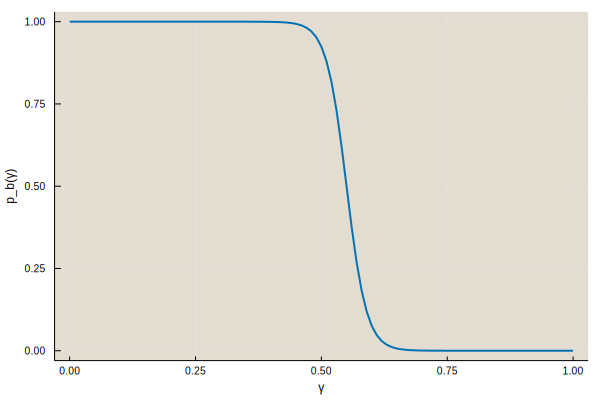

In [14]:
plot(
    0:1/100:1, 
    [pb(γ, 100, n, l_0, gap) for γ in 0:1/100:1],
    xlabel="γ",
    ylabel="p_b(γ)",
    linewidth=2
)

### Free Fitness

Next, let's have look at free fitness and check if it looks appropriate.

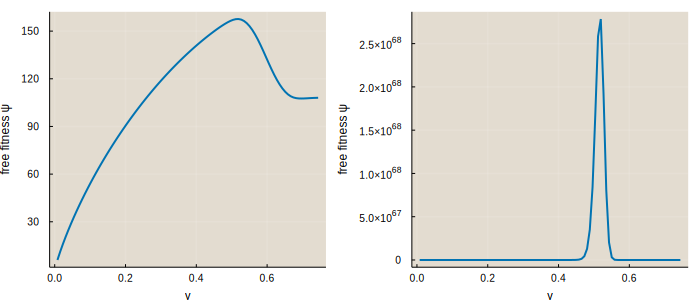

In [15]:
x, y = Ψ(129, n, l_0, gap, f0, fl, 0)
p1 = plot(
    x,
    y,
    xlabel="γ",
    ylabel="free fitness ψ",
    linewidth=2
)
p2 = plot(
    x,
    exp.(y),
    xlabel="γ",
    ylabel="free fitness ψ",
    linewidth=2
)
plot([p1, p2]..., size=(700, 300))

### Optimality with static length

To find the optimal intensive energy, we can interpolate the maximum with a quadratic function and compute the maximum.

In [16]:
function γ_star(l, n, l_0, gap, f0, fl, κ)
    x, y = Ψ(l, n, l_0, gap, f0, fl, κ) 
    max_ind = argmax(y)
    if max_ind == length(x)
        return x[end]
    elseif max_ind == 1
        return x[1]
    else
        f = fit(x[max_ind-1:max_ind+1], y[max_ind-1:max_ind+1], 2)
        return -f[1]/2f[2]
    end
end

γ_star (generic function with 1 method)

Let's add some extra functions to evaluate fitness and binding probability at the optimal intensive energy.

In [17]:
Fstar(l, n, l_0, gap, f0, fl, κ) = F(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

pb_star(l, n, l_0, gap, f0, fl, κ) = pb(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap)

s_star(l, n, l_0, gap, f0, fl, κ) = F(γ_star(l, n, l_0, gap, f0, fl, κ) - 1/l, l, n, l_0, gap, f0, fl) - 
  F(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)


s_star (generic function with 1 method)

## L dynamics

Next we investigate length dynamics.

In [18]:
# length-changing mutation steps

# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
s_pp(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

s_pm(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

s_mm(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl) 

s_mp(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl)


# substitution rates of length increase and decrease
v_pp(γ, l, n, l_0, gap, f0, fl) = γ_0(n) * g(s_pp(γ, l, n, l_0, gap, f0, fl))

v_pm(γ, l, n, l_0, gap, f0, fl) = (1 - γ_0(n)) * g(s_pm(γ, l, n, l_0, gap, f0, fl))

v_plus(γ, l, n, l_0, gap, f0, fl) = v_pp(γ, l, n, l_0, gap, f0, fl) + v_pm(γ, l, n, l_0, gap, f0, fl)

v_plus_star(l, n, l_0, gap, f0, fl, κ) = v_plus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

v_mm(γ, l, n, l_0, gap, f0, fl) = γ * g(s_mm(γ, l, n, l_0, gap, f0, fl)) 

v_mp(γ, l, n, l_0, gap, f0, fl) = (1 - γ) * g(s_mp(γ, l, n, l_0, gap, f0, fl))

v_minus(γ, l, n, l_0, gap, f0, fl) = v_mm(γ, l, n, l_0, gap, f0, fl) + v_mp(γ, l, n, l_0, gap, f0, fl) 

v_minus_star(l, n, l_0, gap, f0, fl, κ) = v_minus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

# Effective Fitness
F_eff(l, n, l_0, gap, f0, fl, κ, lmin) = sum([log(v_plus_star(l_, n, l_0, gap, f0, fl, κ)/
    v_minus_star(l_+1, n, l_0, gap, f0, fl, κ)) for l_  in lmin:l])

# minimal length of functional sites, from condition γ_1(lmin, l_0) + l_0/(l_min * gap) = 1 
#l_min(n, l_0, gap) = ceil(l_0 * (gap + 1) / ((1 - γ_0(n)) * gap)) 

F_eff (generic function with 1 method)

In [19]:
γ_star_list(n, l_0, gap, f0, fl, κ, l_max=200) = [l > 10 ? γ_star(l, n, l_0, gap, f0, fl, κ) : missing  for l in 1:l_max]

function l_star(n, l_0, gap, f0, fl, κ, l_max=200) 
    gstarlist = γ_star_list(n, l_0, gap, f0, fl, κ, l_max)
    funct_pos_list = []
    for l in 1:l_max
        if (~ismissing(gstarlist[l])) && (gstarlist[l] < γ_1(l, n, l_0))
            push!(funct_pos_list, l)
        end
    end
    γ_fun_list = gstarlist[funct_pos_list]
    lm = funct_pos_list[1]
    f_list = zeros(l_max)

    f_list[lm+1:l_max] = cumsum([log(v_plus(gstarlist[i-1], i-1, n, l_0, gap, f0, fl)/
                v_minus(gstarlist[i], i, n, l_0, gap, f0, fl)) for i in lm+1:l_max])
    max_ind = argmax(f_list)
        
    fmax = f_list[max_ind]
    lst = max_ind
    return gstarlist, γ_fun_list, f_list, fmax, lst, lm
end

l_star (generic function with 2 methods)

lstar = 65
γ star = 0.31581124473218525
minimal length of functional sites: 29


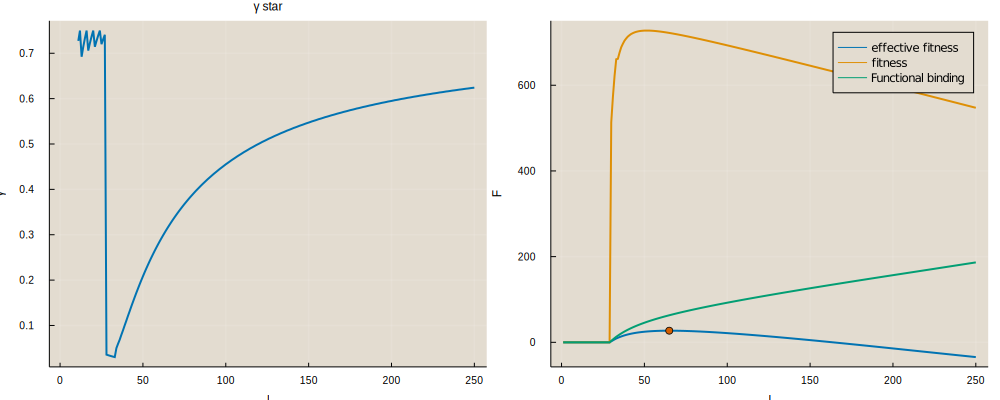

In [20]:
gstarlist, γ_fun_list, f_list, fmax, lst, lm = l_star(n, l_0, gap, f0, fl, 0, lmax)
println("lstar = ", lst)
println("γ star = ", gstarlist[lst])
println("minimal length of functional sites: ", lm)
p1 = plot(gstarlist, xlabel="l", ylabel="γ", title="γ star", linewidth=2)

    
fb = [l>lm ? f_list[l] - F_c(l, l_0, fl) + F_c(lm, l_0, fl) : 0 for l in 1:lmax]
f = [l>lm ? F(gstarlist[l], l, n, l_0, gap, f0, fl) : 0 for l in 1:lmax]
p2 = plot(f_list, xlabel="l", ylabel="F", label="effective fitness", linewidth=2, legend=:topright)
plot!(p2, f, linewidth=2, label="fitness")
plot!(p2, fb, linewidth=2, label="Functional binding")


scatter!(p2, [lst], [fmax])
plot([p1, p2]..., size=(1000, 400))

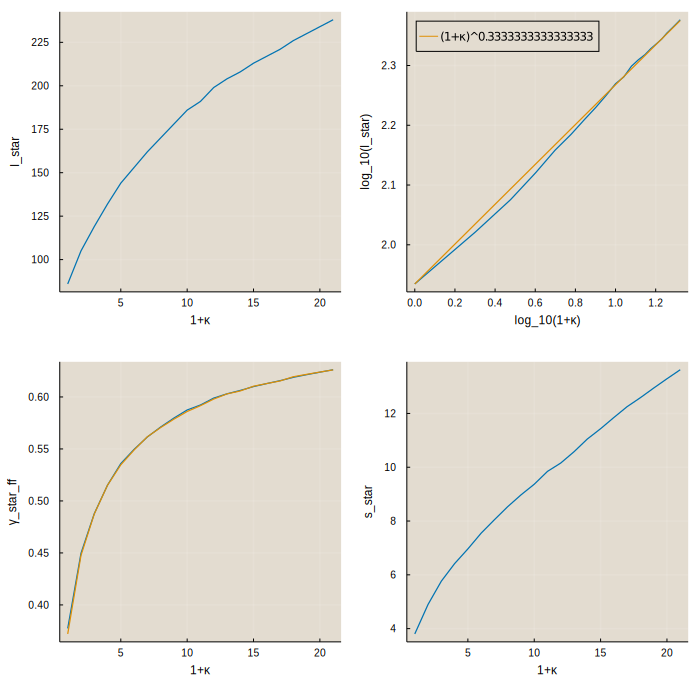

In [37]:
x = collect(0:1:20)
y = [l_star(n, l_0, gap, f0, fl, κ, lmax)[5] for κ in 0:1:20]


gstar = [γ_star(l, n, l_0, gap, f0, fl, κ) for (l, κ) in zip(y, collect(0:1:20))]
sstar = [s_star(l, n, l_0, gap, f0, fl, κ) for (l, κ) in zip(y, collect(0:1:20))]

gstarff = []
for (κ, l) in zip(x, y)
    x_ff, y_ff = Ψ(l, n, l_0, gap, f0, fl, κ)
    push!(gstarff, x_ff[argmax(y_ff)])
end

p_l = plot(
    x .+ 1, 
    y,
    xlabel="1+κ",
    ylabel="l_star"
)


p_l_log = plot(
    log10.(x .+ 1), 
    log10.(y),
    xlabel="log_10(1+κ)",
    ylabel="log_10(l_star)"
)
exponent = 1/3
plot!(p_l_log, log10.(x .+ 1), exponent * log10.(x .+ 1) .+ log10(y[1]), label="(1+κ)^$exponent", legend=:topleft)

p_g = plot(x.+1, gstar, xlabel="1+κ", ylabel="γ_star")
plot!(x.+1, gstarff, xlabel="1+κ", ylabel="γ_star_ff")

p_s = plot(x.+1, sstar, xlabel="1+κ", ylabel="s_star")

plot([p_l, p_l_log, p_g, p_s]..., size=(700, 700, 350), layout=(2,2), bottom_margin=3mm)

In [38]:
y

21-element Array{Int64,1}:
  86
 105
 119
 132
 144
 153
 162
 170
 178
 186
 191
 199
 204
 208
 213
 217
 221
 226
 230
 234
 238

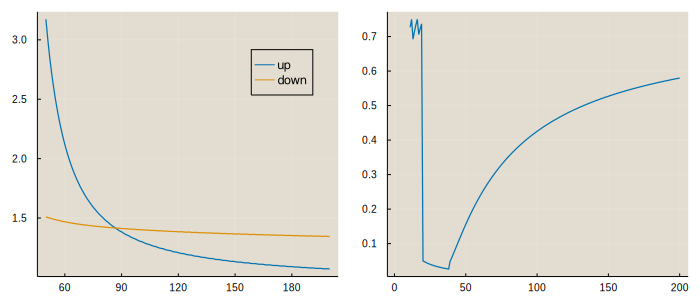

In [31]:
κ = 0
gstar_list, _, _, _, lm = l_star(n, l_0, gap, f0, fl, κ)
lm=50
Up = [v_plus(γ_star(l-1, n, l_0, gap, f0, fl, κ),l-1, n, l_0, gap, f0, fl) for l in lm:200]
Down = [v_minus(γ_star(l, n, l_0, gap, f0, fl, κ),l, n, l_0, gap, f0, fl) for l in lm:200]

F_EFF = [F_eff(l, n, l_0, gap, f0, fl, κ, lm) for l in lm:200]

p1 = plot(lm:200, Up, label="up")
plot!(lm:200, Down, label="down")
#scatter!([63], [Up[14]], color="gray")
p2 = plot(l_star(n, l_0, gap, f0, fl, κ)[1])
plot([p1, p2]..., size=(700, 300))

In [32]:
l
p = plot()
p2 = plot()
exponents = []
for l in 40:25:300
    y = [γ_star(l, n, l_0, gap, f0, fl, κ) for κ in 0:1:20]
    push!(exponents, (y[end]-y[1])/20)
    plot!(p, y , label=l)
    
    plot!(p2, log.(1 .+ collect(0:1:20)), log.(y))
end
p3 = plot(40:25:300, exponents)
plot()
plot([p, p2, p3]..., size=(1000, 300), layout=(1,3))


LoadError: UndefVarError: l not defined

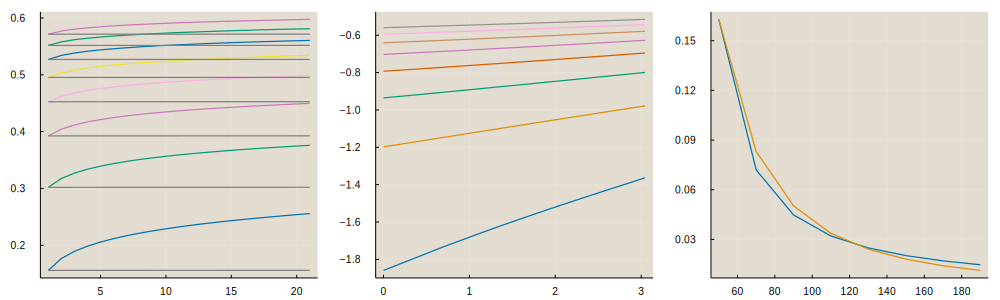

In [33]:

p = plot()
p2 = plot()
exponents = []
for l in 50:20:200
    y = [γ_star(l, n, l_0, gap, f0, fl, κ) for κ in 0:1:20]
    push!(exponents, (log(y[end])-log(y[1]))/(log(21)))
    plot!(p, y)
    plot!(p, 1 .+ collect(0:1:20), (1 .+ collect(0:1:20)).^(1/l^2) * y[1], color="gray")
    
    plot!(p2, log.(1 .+ collect(0:1:20)), log.(y))
end
p3 = plot(50:20:200, exponents)
wtf = -2.
plot!(p3, (50:20:200),  (50:20:200).^wtf ./50. ^wtf * exponents[1])
plot()
plot([p, p2, p3]..., size=(1000, 300), layout=(1,3))


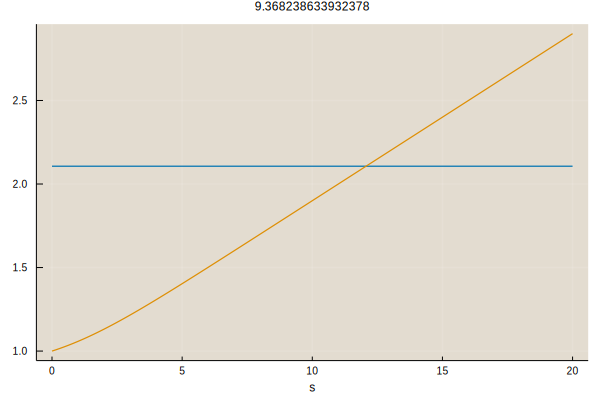

In [34]:
i=10
plot([0, 20], ones(2) .* (1 .- gstar[i]) ./ (gstar[i] .* (1 - (n-2)/(n-1))))

#gs = [g(s) for s in sstar]
#gms = [g(-s) for s in sstar]
x = collect(0:0.01:20)
κ = collect(0:1:20)[i]
plot!(x, [(g(s) .+ κ) ./ (g(-s) .+ κ) for s in x], xlabel="s", title=sstar[i])

### Numerics

In [35]:
N = 1000
steps = 10^6

1000000

In [17]:
f_num = Jevo.num_fermi(n, l_0, gap, f0/2N, fl/2N)

Jevo.num_fermi(4, 20, 10, 1.2, 0.016)

In [18]:
emat = gap/l_0 * (ones(n, n) - Matrix{Float64}(I, n, n))
trace = zeros(Float64, 50)
l = 100
κ = 10
for j in 1:50
    pop = Jevo.mono_pop(N=N, l=l)
    Jevo.initiate!(pop, emat)
    for i in 1:steps
        Jevo.bp_substitution!(pop, emat, f_num)
        if rand() < κ/N
            Jevo.driver_mutation!(pop)
        end
    end
    trace[j] = Jevo.get_energy(pop, emat) *l_0/l/gap
end

In [19]:
f_plot = Jevo.fitness.((l*gap/l_0) .* (minimum(trace)-3/l:1/l:maximum(trace)+3/l), l, f_num);

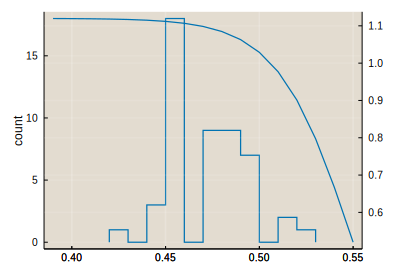

In [20]:
p = Jedi.histogram(data=trace)
plot!(twinx(), minimum(trace)-3/l:1/l:maximum(trace)+3/l, f_plot)

## Simulation data

In [21]:
params = Jevo.parse_metadata("../outputs/2020_12_30_METADATA.txt")
df = CSV.read("../outputs/2020_12_30_results.csv", DataFrame)
gdf = combine(groupby(df, ["gamma", "l", "kappa"]), nrow);
f0 = parse(Float64, params["f0"])

400.0

In [22]:
maxima = combine(groupby(gdf, ["l", "kappa"]), :nrow => argmax);
gamma_max = Float64[]
for i in 1:length(groupby(gdf, ["l", "kappa"]))  
     push!(gamma_max, groupby(gdf, ["l", "kappa"])[i][maxima[i, :nrow_argmax], :gamma])
end

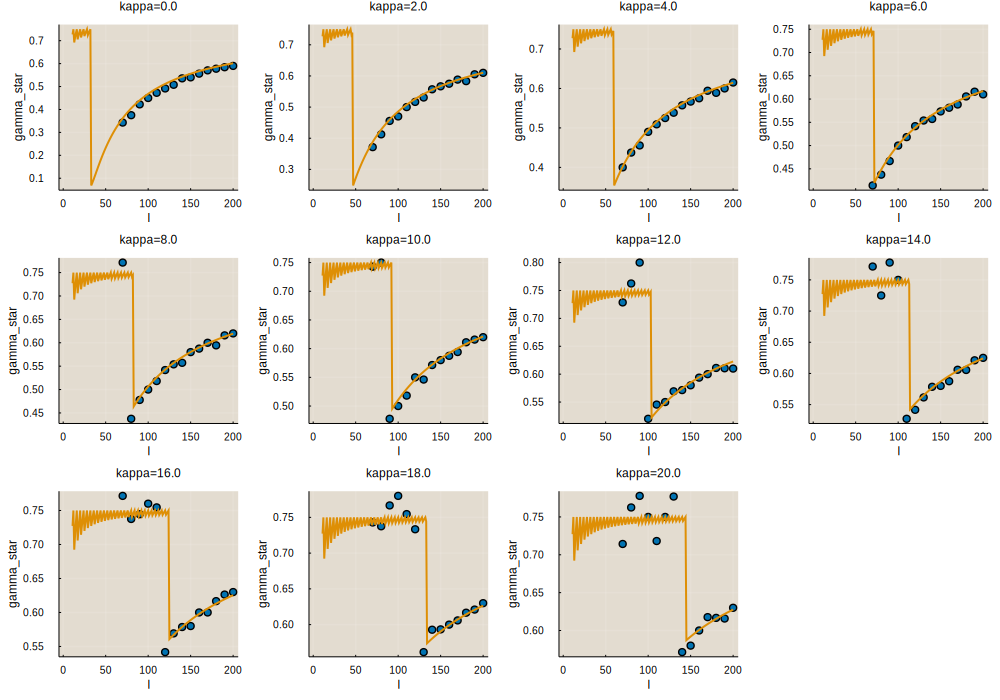

In [23]:
maxima.gamma_max = gamma_max
maxima = maxima[:, [:l, :kappa, :gamma_max]]

p_list = []
for κ in unique(maxima.kappa)
    x = maxima[maxima.kappa .== κ, :l]
    y = maxima[maxima.kappa .== κ, :gamma_max]
    y_theory = γ_star_list(n, l_0, gap, f0, fl, κ)
    p = scatter(x, y, title="kappa"*"=$(κ)", xlabel="l", ylabel="gamma_star")
    plot!(y_theory, linewidth=2)
    push!(p_list, p)
end
plot(p_list...,size=(1000, 700))

In [24]:
savefig("strong_selection_gamma_star.pdf")

In [25]:
params2 = Jevo.parse_metadata("../outputs/2021_01_05_METADATA.txt")
df2 = CSV.read("../outputs/2021_01_05_results.csv", DataFrame)
gdf2 = combine(groupby(df2, :kappa), [:l, :gamma] => ((x, y) -> (l_mean=mean(x), l_std=std(x), gamma_mean=mean(y))) => AsTable)
f0=parse(Float64, params2["f0"])
fl=parse(Float64, params2["fl"])

14.0

In [26]:
gdf3 = combine(groupby(df2, [:kappa, :l]), nrow);

In [27]:
gdf3 = combine(groupby(df2, [:kappa, :l]), nrow)
maxima = combine(groupby(gdf3, ["kappa"]), :nrow => argmax);
l_max = Float64[]
for i in 1:length(groupby(gdf3, ["kappa"]))  
     push!(l_max, groupby(gdf3, ["kappa"])[i][maxima[i, :nrow_argmax], :l])
end

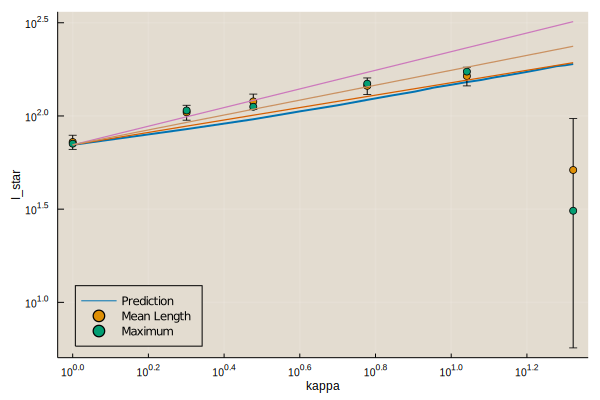

In [28]:
x = collect(0:1:20)
y = [l_star(n, l_0, gap, f0, fl, κ)[5] for κ in 0:1:20]

p_l = plot(
    x .+ 1, 
    y,
    xlabel="kappa",
    ylabel="l_star",
    linewidth=2,
    label="Prediction",
    xscale=:log10,
    yscale=:log10,
    legend=:bottomleft
)


#scatter(gdf2.kappa.+1, gdf2.l_mean, xscale=:log10, yscale=:log10)
#plot!(gdf2.kappa.+1, (gdf2.kappa.+1).^(1/3) * gdf2.l_mean[1])
scatter!(p_l, gdf2.kappa .+ 1, gdf2.l_mean, yerror=(gdf2.l_std), label="Mean Length")
scatter!(p_l, gdf2.kappa .+ 1, l_max, label="Maximum")
plot!(p_l, gdf2.kappa .+ 1, (gdf2.kappa .+ 1) .^ (1/3) * y[1])
plot!(p_l, gdf2.kappa .+ 1, (gdf2.kappa .+ 1) .^ (1/2) * y[1])
plot!(p_l, gdf2.kappa .+ 1, (gdf2.kappa .+ 1) .^ (1/2.5) * y[1])

In [29]:
savefig("l_star.pdf")

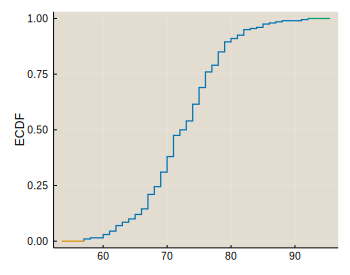

In [30]:
Jedi.ecdf(df2[df2.kappa .== 0, :l], staircase=true)

In [31]:
DataFrame(columns=[:A])

,columns
,Symbol
1,A
